In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score,plot_roc_curve,roc_curve
from sklearn.model_selection import train_test_split

##classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn import model_selection
from numpy import mean
from sklearn.model_selection import cross_val_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def EER_score(y_true,y_pred):
  fpr, tpr, thresholds = roc_curve(y_true,y_pred)
  eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
  thresh = interp1d(fpr, thresholds)(eer)
  return eer

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head()
test.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [4]:
test.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

since there were no nulls we don't need to clean the data

In [6]:
train['churn'].value_counts()

no     3652
yes     598
Name: churn, dtype: int64

There is an imbalance

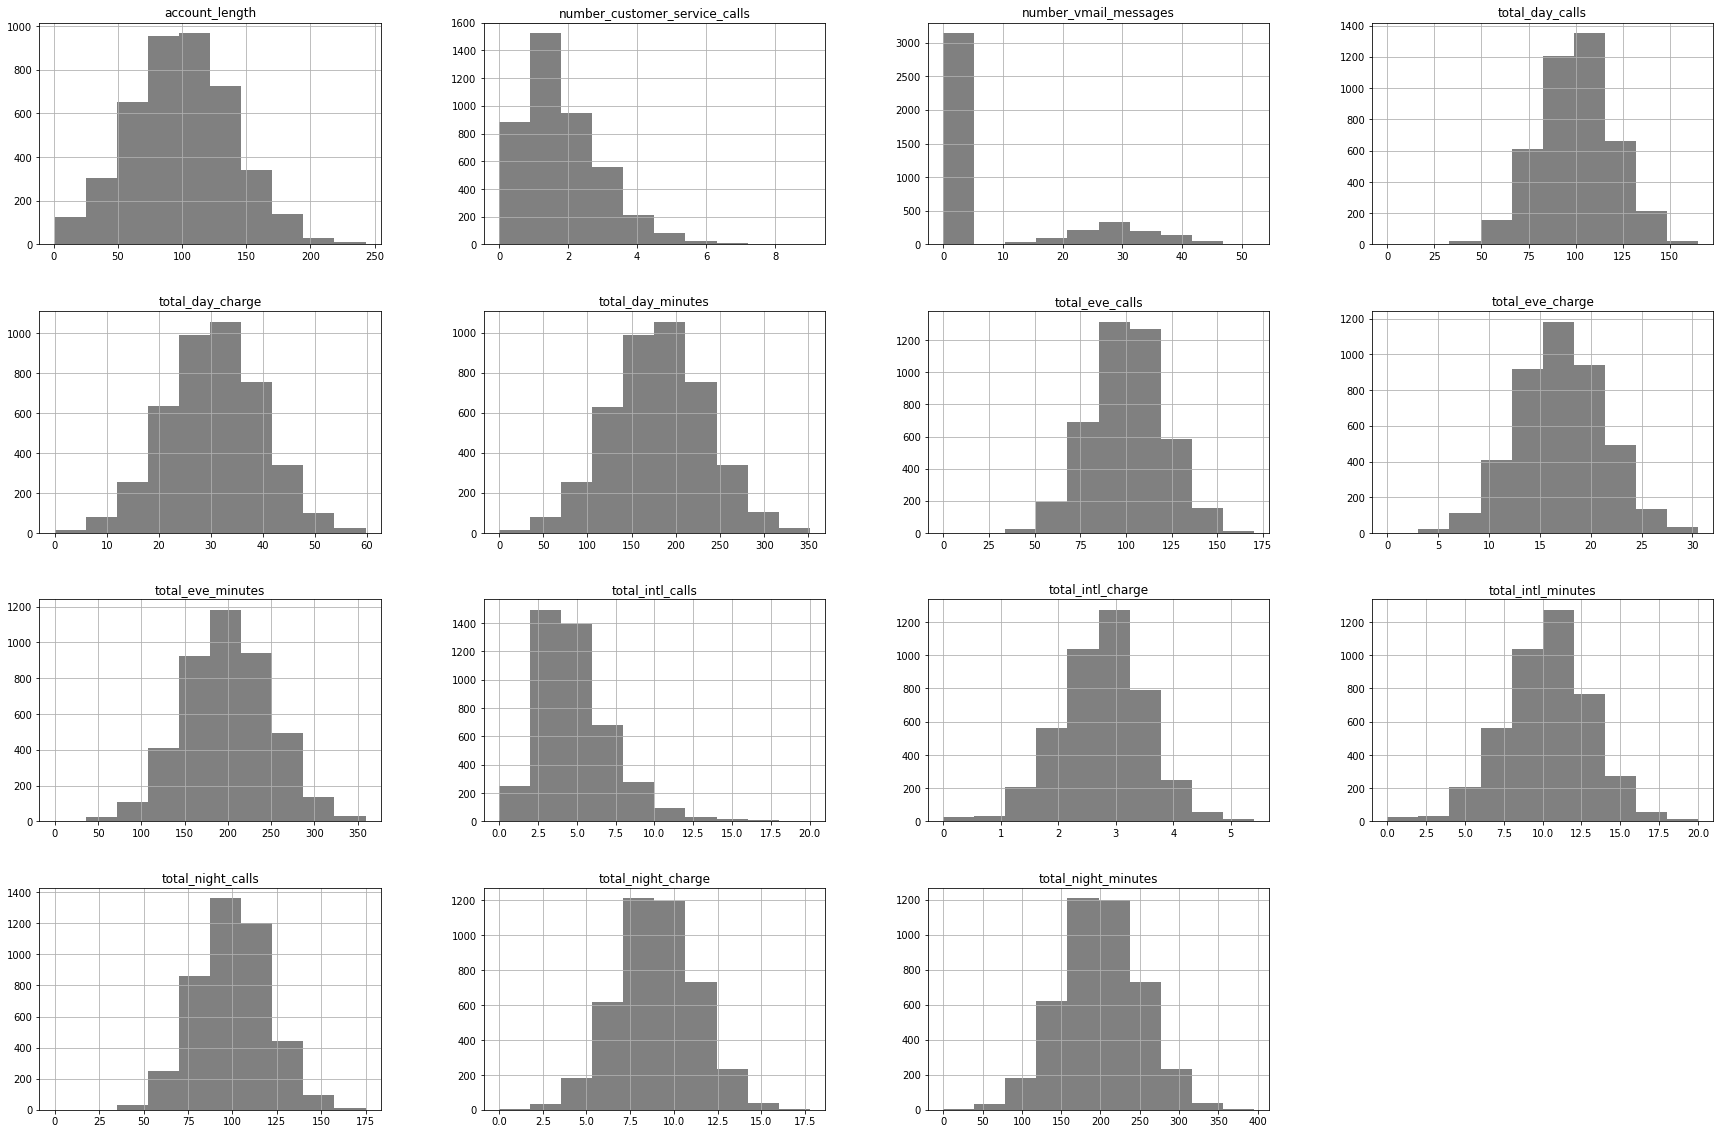

In [7]:
train.hist(color='grey',figsize=(30, 20))
plt.show()

In [8]:
train=pd.get_dummies(train, columns=["state", "area_code"], prefix=["state", "area_code"])
##train['state'] = pd.Categorical(train['state']).codes 
##train['area_code'] = pd.Categorical(train['area_code']).codes
train['international_plan'] = pd.Categorical(train['international_plan']).codes   ##binary
train['voice_mail_plan'] = pd.Categorical(train['voice_mail_plan']).codes ##binary
train['churn'] = pd.Categorical(train['churn']).codes ##binary
train


,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510
0,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,121,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,83,0,0,0,188.3,70,32.01,243.8,88,20.72,213.7,79,9.62,10.3,6,2.78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4246,73,0,0,0,177.9,89,30.24,131.2,82,11.15,186.2,89,8.38,11.5,6,3.11,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4247,75,0,0,0,170.7,101,29.02,193.1,126,16.41,129.1,104,5.81,6.9,7,1.86,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4248,50,0,1,40,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [9]:
X=train
Xsample=X.sample(frac=0.1,random_state=1)
y=Xsample['churn']
Xsample=Xsample.drop('churn',axis=1)



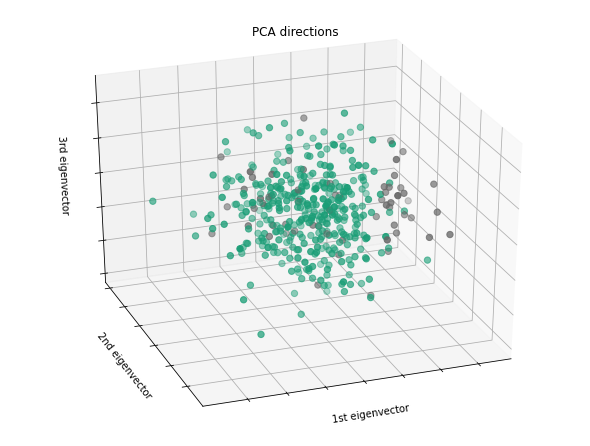

In [10]:
reduced = PCA(n_components=3).fit_transform(Xsample)
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], c=y, cmap=plt.cm.Dark2,s=40)
ax.set_title("PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.show()



use SVM, MLP, random forest, naive bayes,knn.

In [11]:
y=train['churn']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

k_range = list(range(1,26))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)

    scores.append([metrics.accuracy_score(y_test,y_pred),metrics.precision_score(y_test,y_pred,average='micro'),metrics.recall_score(y_test,y_pred,average='micro'),roc_auc_score(y_test,y_pred)])

scores_df=pd.DataFrame(scores)



In [12]:
print(scores_df)

           0         1         2         3
0   0.808981  0.808981  0.808981  0.626381
1   0.888810  0.888810  0.888810  0.624222
2   0.885246  0.885246  0.885246  0.674890
3   0.897363  0.897363  0.897363  0.638317
4   0.898788  0.898788  0.898788  0.659768
5   0.900927  0.900927  0.900927  0.638077
6   0.903065  0.903065  0.903065  0.662231
7   0.898788  0.898788  0.898788  0.632262
8   0.903065  0.903065  0.903065  0.655354
9   0.901639  0.901639  0.901639  0.638488
10  0.901639  0.901639  0.901639  0.643072
11  0.900927  0.900927  0.900927  0.638077
12  0.902352  0.902352  0.902352  0.648067
13  0.899501  0.899501  0.899501  0.628088
14  0.900214  0.900214  0.900214  0.637667
15  0.900214  0.900214  0.900214  0.633083
16  0.903065  0.903065  0.903065  0.643893
17  0.898788  0.898788  0.898788  0.625385
18  0.902352  0.902352  0.902352  0.641191
19  0.899501  0.899501  0.899501  0.625795
20  0.903065  0.903065  0.903065  0.639309
21  0.898788  0.898788  0.898788  0.623093
22  0.90306


Confusion matrix: 
 [[1198   20]
 [ 136   49]]

Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      1218
           1       0.71      0.26      0.39       185

    accuracy                           0.89      1403
   macro avg       0.80      0.62      0.66      1403
weighted avg       0.87      0.89      0.87      1403

Accuracy score =  0.8888096935138988
EER score =  0.42772375399583756


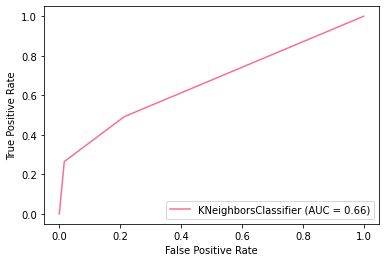

In [13]:
knn = KNeighborsClassifier(n_neighbors=scores_df.idxmax()[3])
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print('\nConfusion matrix: \n',confusion_matrix(y_test, y_pred))
print('\nClassification report: \n',classification_report(y_test, y_pred))
print('Accuracy score = ',accuracy_score(y_test, y_pred))
print('EER score = ',EER_score(y_test,y_pred))
knndisp = plot_roc_curve(knn, X_test, y_test)
plt.show()

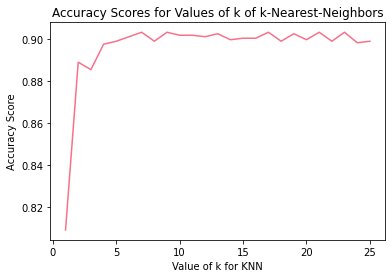

In [14]:
plt.plot(k_range, scores_df.loc[:,0])
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

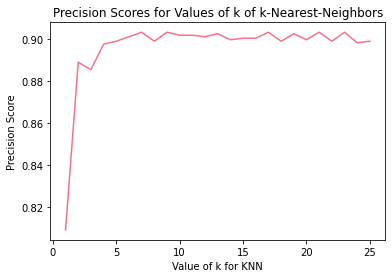

In [15]:
plt.plot(k_range, scores_df.loc[:,1])
plt.xlabel('Value of k for KNN')
plt.ylabel('Precision Score')
plt.title('Precision Scores for Values of k of k-Nearest-Neighbors')
plt.show()

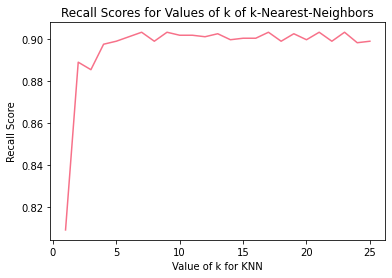

In [16]:
plt.plot(k_range, scores_df.loc[:,2])
plt.xlabel('Value of k for KNN')
plt.ylabel('Recall Score')
plt.title('Recall Scores for Values of k of k-Nearest-Neighbors')
plt.show()

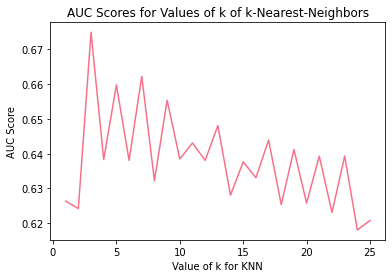

In [17]:
plt.plot(k_range, scores_df.loc[:,3])
plt.xlabel('Value of k for KNN')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Values of k of k-Nearest-Neighbors')
plt.show()



Confusion matrix: 
 [[1218    0]
 [   0  185]]

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1218
           1       1.00      1.00      1.00       185

    accuracy                           1.00      1403
   macro avg       1.00      1.00      1.00      1403
weighted avg       1.00      1.00      1.00      1403

Accuracy score =  1.0
EER score =  0.0


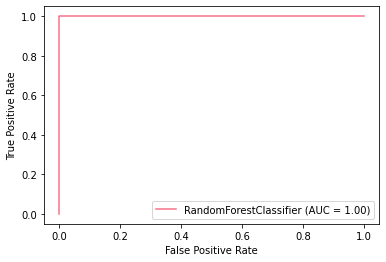

In [18]:
RFClassifier = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42,class_weight='balanced_subsample')
RFClassifier.fit(X_train, y_train)
y_pred = RFClassifier.predict(X_test)

print('\nConfusion matrix: \n',confusion_matrix(y_test, y_pred))
print('\nClassification report: \n',classification_report(y_test, y_pred))
print('Accuracy score = ',accuracy_score(y_test, y_pred))
print('EER score = ',EER_score(y_test,y_pred))

RFClassifierdisp = plot_roc_curve(RFClassifier, X_test, y_test)
plt.show()


Confusion matrix: 
 [[1217    1]
 [   0  185]]

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1218
           1       0.99      1.00      1.00       185

    accuracy                           1.00      1403
   macro avg       1.00      1.00      1.00      1403
weighted avg       1.00      1.00      1.00      1403

Accuracy score =  0.9992872416250891
EER score =  0.0008203445447087776


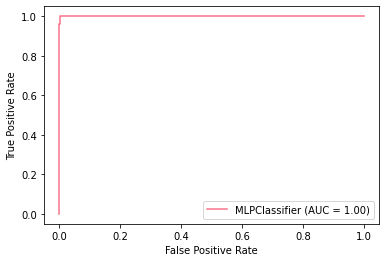

In [19]:

MLP = MLPClassifier(activation='relu', 
       hidden_layer_sizes=(250, 150, 50), random_state=7,
       shuffle=True, solver='adam'
       )
y_pred=MLP.fit(X_train, y_train).predict(X_test)
print('\nConfusion matrix: \n',confusion_matrix(y_test, y_pred))
print('\nClassification report: \n',classification_report(y_test, y_pred))
print('Accuracy score = ',accuracy_score(y_test, y_pred))
print('EER score = ',EER_score(y_test,y_pred))


disp = plot_roc_curve(MLP, X_test, y_test)
plt.show()


Confusion matrix: 
 [[1218    0]
 [   0  185]]

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1218
           1       1.00      1.00      1.00       185

    accuracy                           1.00      1403
   macro avg       1.00      1.00      1.00      1403
weighted avg       1.00      1.00      1.00      1403

Accuracy score =  1.0
EER score =  0.0


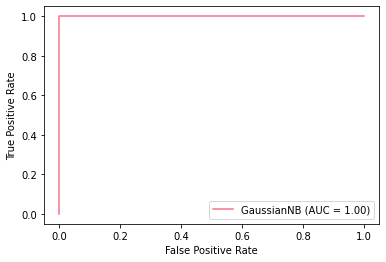

In [20]:

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('\nConfusion matrix: \n',confusion_matrix(y_test, y_pred))
print('\nClassification report: \n',classification_report(y_test, y_pred))
print('Accuracy score = ',accuracy_score(y_test, y_pred))
print('EER score = ',EER_score(y_test,y_pred))


disp = plot_roc_curve(gnb, X_test, y_test)
plt.show()



Confusion matrix: 
 [[1188   30]
 [ 102   83]]

Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      1218
           1       0.73      0.45      0.56       185

    accuracy                           0.91      1403
   macro avg       0.83      0.71      0.75      1403
weighted avg       0.90      0.91      0.90      1403

Accuracy score =  0.9059158945117605
EER score =  0.361134365843219


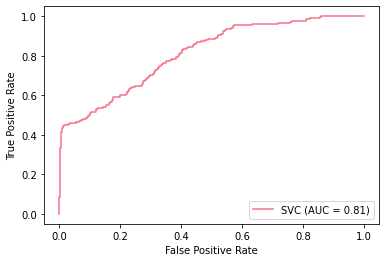

In [21]:

PSVC = SVC(kernel='poly',degree=10,class_weight='balanced',random_state=7)
PSVC.fit(X_train, y_train)
y_pred = PSVC.predict(X_test)
print('\nConfusion matrix: \n',confusion_matrix(y_test, y_pred))
print('\nClassification report: \n',classification_report(y_test, y_pred))
print('Accuracy score = ',accuracy_score(y_test, y_pred))
print('EER score = ',EER_score(y_test,y_pred))
disp = plot_roc_curve(PSVC, X_test, y_test)
plt.show()

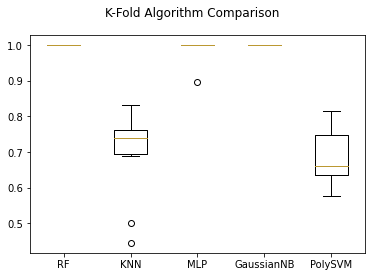

In [22]:
models = []
models.append(('RF', RFClassifier))
models.append(('KNN', knn))
models.append(('MLP', MLP))
models.append(('GaussianNB', gnb))
models.append(('PolySVM', PSVC))
results2 = []
names = []
scoring = 'precision'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=7,shuffle=True)
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results2.append(cv_results)
	names.append(name)

fig = plt.figure()
fig.suptitle('K-Fold Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names)
plt.show()

In [23]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X,y)
unique, counts = np.unique(y_smt, return_counts=True)
dict(zip(unique, counts))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


{0: 3636, 1: 3636}

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_smt,y_smt,test_size=0.33)

k_range = list(range(1,26))
scores = []
for k in k_range:
    knn_smote = KNeighborsClassifier(n_neighbors=k)
    knn_smote.fit(X_train,y_train)
    y_pred = knn_smote.predict(X_test)

    scores.append([metrics.accuracy_score(y_test,y_pred),metrics.precision_score(y_test,y_pred,average='micro'),metrics.recall_score(y_test,y_pred,average='micro'),roc_auc_score(y_test,y_pred)])

scores_df=pd.DataFrame(scores)



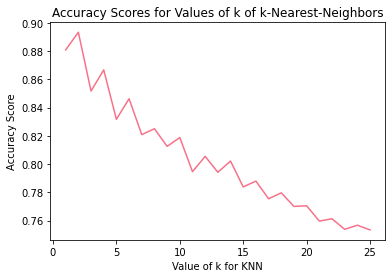

In [25]:
plt.plot(k_range, scores_df.loc[:,0])
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

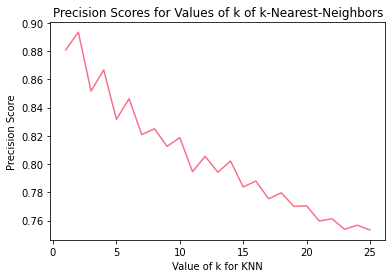

In [26]:
plt.plot(k_range, scores_df.loc[:,1])
plt.xlabel('Value of k for KNN')
plt.ylabel('Precision Score')
plt.title('Precision Scores for Values of k of k-Nearest-Neighbors')
plt.show()

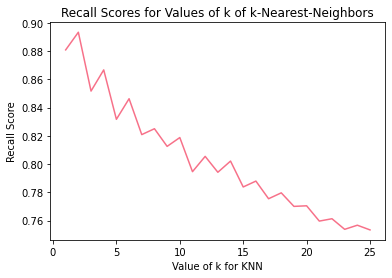

In [27]:
plt.plot(k_range, scores_df.loc[:,2])
plt.xlabel('Value of k for KNN')
plt.ylabel('Recall Score')
plt.title('Recall Scores for Values of k of k-Nearest-Neighbors')
plt.show()

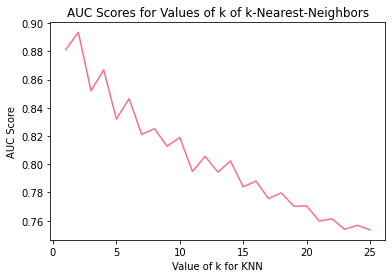

In [28]:
plt.plot(k_range, scores_df.loc[:,3])
plt.xlabel('Value of k for KNN')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Values of k of k-Nearest-Neighbors')
plt.show()



Confusion matrix: 
 [[ 927  276]
 [  10 1187]]

Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.77      0.87      1203
           1       0.81      0.99      0.89      1197

    accuracy                           0.88      2400
   macro avg       0.90      0.88      0.88      2400
weighted avg       0.90      0.88      0.88      2400

Accuracy score =  0.8808333333333334
EER score =  0.18788932471835543


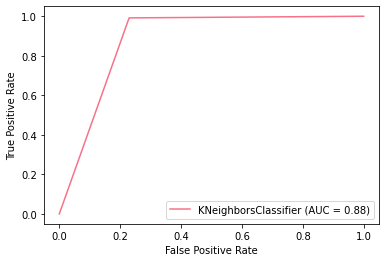

In [29]:
knn_smote = KNeighborsClassifier(n_neighbors=scores_df.idxmax()[3])
knn_smote.fit(X_train,y_train)
y_pred = knn_smote.predict(X_test)
print('\nConfusion matrix: \n',confusion_matrix(y_test, y_pred))
print('\nClassification report: \n',classification_report(y_test, y_pred))
print('Accuracy score = ',accuracy_score(y_test, y_pred))
print('EER score = ',EER_score(y_test,y_pred))
knndisp = plot_roc_curve(knn_smote, X_test, y_test)
plt.show()


Confusion matrix: 
 [[1203    0]
 [   0 1197]]

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1203
           1       1.00      1.00      1.00      1197

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400

Accuracy score =  1.0
EER score =  0.0


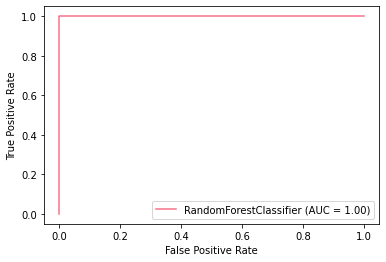

In [30]:
RFClassifier_smote = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42,class_weight='balanced_subsample')
RFClassifier_smote.fit(X_train, y_train)
y_pred = RFClassifier_smote.predict(X_test)

print('\nConfusion matrix: \n',confusion_matrix(y_test, y_pred))
print('\nClassification report: \n',classification_report(y_test, y_pred))
print('Accuracy score = ',accuracy_score(y_test, y_pred))
print('EER score = ',EER_score(y_test,y_pred))

RFClassifierdisp = plot_roc_curve(RFClassifier_smote, X_test, y_test)
plt.show()


Confusion matrix: 
 [[1203    0]
 [   0 1197]]

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1203
           1       1.00      1.00      1.00      1197

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400

Accuracy score =  1.0
EER score =  0.0


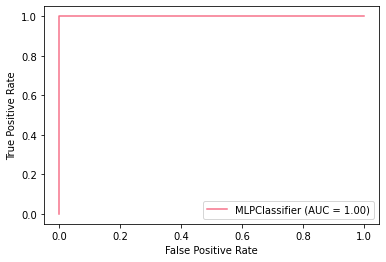

In [31]:

MLP_smote = MLPClassifier(activation='relu', 
       hidden_layer_sizes=(250, 150, 50), random_state=7,
       shuffle=True, solver='adam'
       )
y_pred=MLP_smote.fit(X_train, y_train).predict(X_test)
print('\nConfusion matrix: \n',confusion_matrix(y_test, y_pred))
print('\nClassification report: \n',classification_report(y_test, y_pred))
print('Accuracy score = ',accuracy_score(y_test, y_pred))
print('EER score = ',EER_score(y_test,y_pred))


disp = plot_roc_curve(MLP_smote, X_test, y_test)
plt.show()


Confusion matrix: 
 [[1203    0]
 [   0 1197]]

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1203
           1       1.00      1.00      1.00      1197

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400

Accuracy score =  1.0
EER score =  0.0


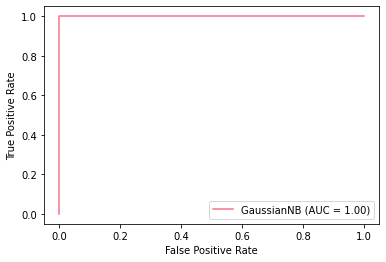

In [32]:

gnb_smote = GaussianNB()
y_pred = gnb_smote.fit(X_train, y_train).predict(X_test)

print('\nConfusion matrix: \n',confusion_matrix(y_test, y_pred))
print('\nClassification report: \n',classification_report(y_test, y_pred))
print('Accuracy score = ',accuracy_score(y_test, y_pred))
print('EER score = ',EER_score(y_test,y_pred))


disp = plot_roc_curve(gnb_smote, X_test, y_test)
plt.show()


Confusion matrix: 
 [[1178   25]
 [ 638  559]]

Classification report: 
               precision    recall  f1-score   support

           0       0.65      0.98      0.78      1203
           1       0.96      0.47      0.63      1197

    accuracy                           0.72      2400
   macro avg       0.80      0.72      0.70      2400
weighted avg       0.80      0.72      0.70      2400

Accuracy score =  0.72375
EER score =  0.3524619072548425


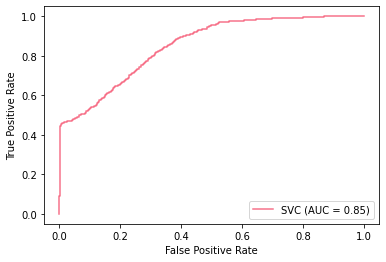

In [33]:

PSVC_smote = SVC(kernel='poly',degree=10,class_weight='balanced',random_state=7)
PSVC_smote.fit(X_train, y_train)
y_pred = PSVC_smote.predict(X_test)
print('\nConfusion matrix: \n',confusion_matrix(y_test, y_pred))
print('\nClassification report: \n',classification_report(y_test, y_pred))
print('Accuracy score = ',accuracy_score(y_test, y_pred))
print('EER score = ',EER_score(y_test,y_pred))
disp = plot_roc_curve(PSVC_smote, X_test, y_test)
plt.show()

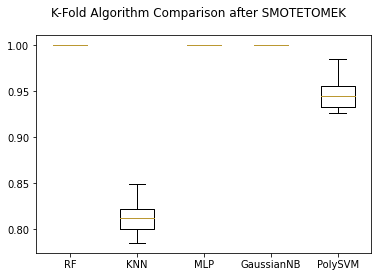

In [34]:

models = []
models.append(('RF', RFClassifier_smote))
models.append(('KNN', knn_smote))
models.append(('MLP', MLP_smote))
models.append(('GaussianNB', gnb_smote))
models.append(('PolySVM', PSVC_smote))
results2 = []
names = []
scoring = 'precision'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=7,shuffle=True)
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results2.append(cv_results)
	names.append(name)

fig = plt.figure()
fig.suptitle('K-Fold Algorithm Comparison after SMOTETOMEK')
ax = fig.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names)
plt.show()

In [35]:
test=pd.get_dummies(test, columns=["state", "area_code"], prefix=["state", "area_code"])
test['international_plan'] = pd.Categorical(test['international_plan']).codes   ##binary
test['voice_mail_plan'] = pd.Categorical(test['voice_mail_plan']).codes ##binary
final_y=RFClassifier_smote.predict(test)

In [47]:
df = pd.DataFrame(final_y,columns=['churn']) 
df.index=df.index+1
df.index.name='id'
df['churn'] = df['churn'].map({1: 'yes', 0: 'no'})
df

,churn
id,
1,yes
2,no
3,yes
4,yes
5,yes
...,...
746,no
747,yes
748,yes


In [48]:
from google.colab import files
df.to_csv('data.csv') 
files.download("data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>